In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.io import loadmat

from aux import loadmat_h5, get_seg, get_outliers, mv_avg, align_t, zscore
from disp import set_plot, plot_b

cc = np.concatenate

T_MAX = 600
T_NRL = np.arange(T_MAX)
NROI = 20

T_SINE = np.array([40, 70, 100])
T_PULSE = np.array([130, 160, 190])
T_NAT = np.array([220, 300, 380, 460])

FLY_IDX = 0

FLIES = ['220815_a1', '220825_a1']
EXPTS = [
    [f'{FLIES[0]}_{ctr+1}' for ctr in range(2)],
    [f'{FLIES[1]}_{ctr+1}' for ctr in range(6)],
]

BHV_IDX_FRAME = 1
BHV_IDX_TIME = 21
BHV_IDX_SPEED = 18
DT_BHV = 1

FNAME_STIM = 'data/original/lin_imaging/nat_song_imaging/10min_blocksplus_stim_1_forplotting.mat'
SAVE_DIR = f'data/view/lin_20220830'

In [2]:
stims = loadmat(FNAME_STIM)
stim_pulse = stims['pulse_song'].flatten()
stim_sine = stims['sine_song'].flatten()
tstim = stims['stim_time'].flatten()

stim = np.zeros(len(tstim), dtype=int)
stim[stim_sine > 0] = 1
stim[stim_pulse > 0] = 2

/Users/rp21/opt/miniconda3/envs/sci/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  func(*args, **kwargs)
/Users/rp21/opt/miniconda3/envs/sci/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


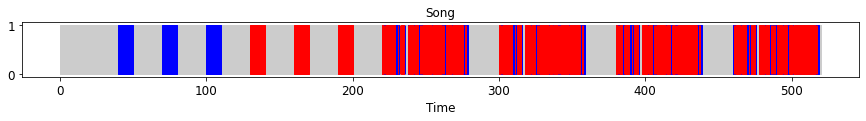

In [3]:
# plot stim
fig, ax = plt.subplots(1, 1, figsize=(15, 1), tight_layout=True)
plot_b(ax, tstim, stim, extent=[0, tstim.max(), 0, 1], c=[(.8, .8, .8), 'b', 'r'])
set_plot(ax, x_label='Time', title='Song', font_size=12)

In [4]:
# load behav
expts = EXPTS[FLY_IDX]
ntr = len(expts)

tbhvs = []
spds = []

for expt in expts:

    fname_bhv = f'data/original/lin_imaging/nat_song_imaging/{expt}/output.txt'

    df_bhv = pd.read_csv(fname_bhv, header=None)

    # df_bhv
    tbhv = np.array(df_bhv)[:, BHV_IDX_TIME] - np.array(df_bhv)[0, BHV_IDX_TIME]
    # converts to time in seconds
    spd = np.array(df_bhv)[:, BHV_IDX_SPEED].astype(float)
    
    tbhvs.append(tbhv)
    spds.append(spd)
    
# clean up time vectors and signal alignment
tbase, spds = align_t(tbhvs, spds, dt=DT_BHV)

In [5]:
# extend stim vec to match behav
dt_stim = np.mean(np.diff(tstim))
tstim = np.arange(0, tbase[-1]+dt_stim, dt_stim)
stim_ = np.zeros(len(tstim))
stim_[:len(stim)] = stim
stim = stim_

mtstim_sine_0 = ((T_SINE[0]-5) < tstim) & (tstim < (T_SINE[0]+15))
mtstim_pulse_0 = ((T_PULSE[0]-5) < tstim) & (tstim < (T_PULSE[0]+15))
mtstim_nat_0 = ((T_NAT[0] - 5) <= tstim) & (tstim < T_NAT[0] + 65)

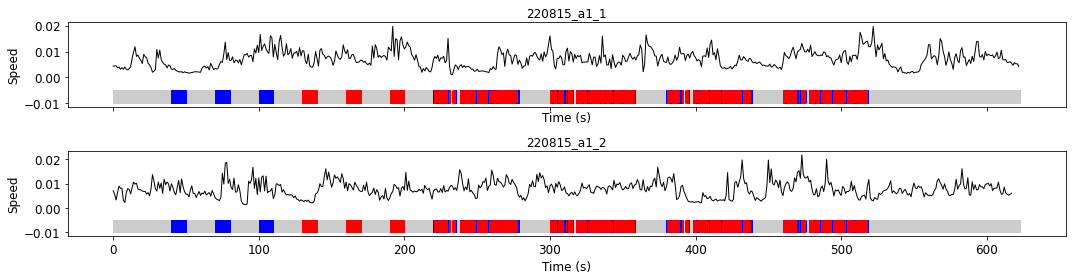

In [6]:
# plot behav
fig, axs = plt.subplots(ntr, 1, figsize=(15, 2*ntr), tight_layout=True, sharex=True)

for ctr, (spd, ax) in enumerate(zip(spds, axs)):

    # plot stim and behav
    ax.plot(tbase, spd, c='k', lw=1)
    plot_b(ax, tstim, stim, extent=[0, tstim.max(), -.01, -.005], c=[(.8, .8, .8), 'b', 'r'])
    set_plot(ax, x_label='Time (s)', y_label='Speed', title=f'{FLIES[FLY_IDX]}_{ctr+1}', font_size=12)

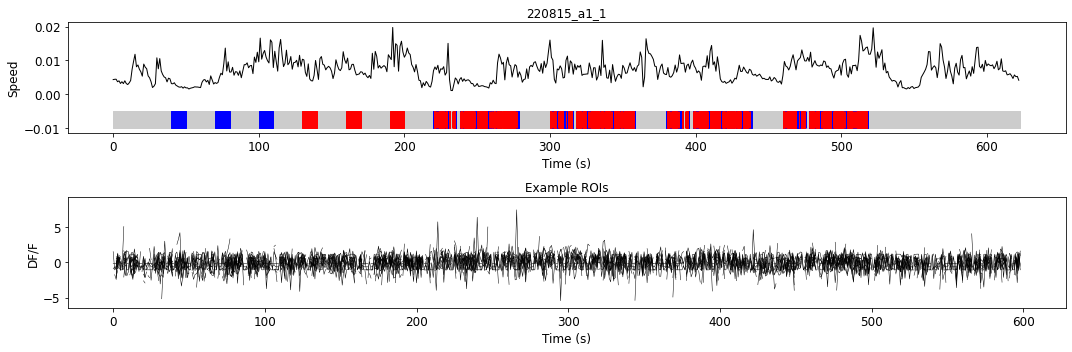

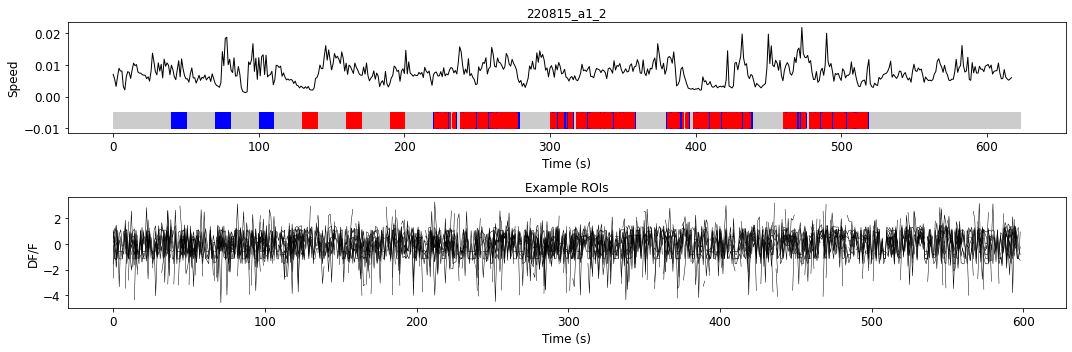

In [7]:
# load all neural data
dffs_all = []

for ctr, expt in enumerate(EXPTS[FLY_IDX]):
    data_dir = f'data/original/lin_imaging/nat_song_imaging/{expt}/supervoxels/'
    
    dffs = []
    for slice in range(0, 9):
        fname = f'{expt}_n20_t600_slice{slice}.h5'
        z_dff = loadmat_h5(os.path.join(data_dir, fname))['z_dff']


        for dff in z_dff.T:

            dff[get_outliers(dff, 3)] = np.nan
            dff = align_t([T_NRL], [dff], dt=DT_BHV, tbase=tbase)[1][0]
#             dff = mv_avg(tbase, dff, 3)

            # z-score
            dff -= np.nanmean(dff)
            dff /= np.nanstd(dff)

            dffs.append(dff)
    
    dffs = np.array(dffs)
    dffs_all.append(dffs)
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True)
    axs[0].plot(tbase, spds[ctr], c='k', lw=1)
    plot_b(axs[0], tstim, stim, extent=[0, tstim.max(), -.01, -.005], c=[(.8, .8, .8), 'b', 'r'])
    set_plot(axs[0], x_label='Time (s)', y_label='Speed', title=f'{FLIES[FLY_IDX]}_{ctr+1}', font_size=12)
    
    axs[1].plot(tbase, (dffs).T[:, :20], c='k', lw=.5)
    set_plot(axs[1], x_label='Time (s)', y_label='DF/F', title='Example ROIs', font_size=12)

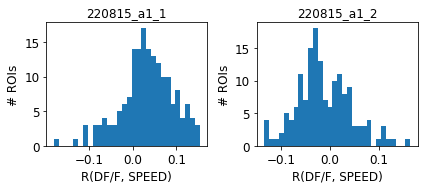

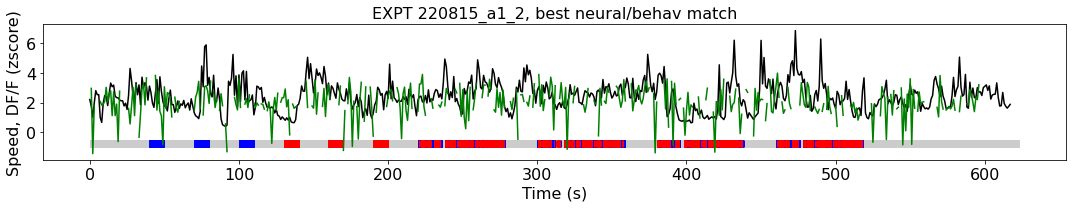

In [8]:
from scipy.stats import linregress

# loop over expts and ROIs and compute corr btwn behav and ROIs
fig, axs = plt.subplots(1, len(expts), figsize=(3*len(expts), 2.75), tight_layout=True)
for expt, spd, dffs, ax in zip(expts, spds, dffs_all, axs):
    rs = np.nan*np.zeros(len(dffs))
    ps = np.nan*np.zeros(len(dffs))
    
    for croi, dff in enumerate(dffs):
        mvalid = ~np.isnan(dff)
        
        if np.sum(mvalid) > 2:
            slp, icpt, r, p, stderr = linregress(spd[mvalid], dff[mvalid])
            
        else:
            r = np.nan
            p = np.nan

        rs[croi] = r
        ps[croi] = p
        
    ax.hist(rs, bins=30)
    set_plot(ax, x_label='R(DF/F, SPEED)', y_label='# ROIs', title=expt, font_size=12)
    
# plot best neural/behav match for final trial
fig, ax = plt.subplots(1, 1, figsize=(15, 3), tight_layout=True)
idx_best = np.nanargmax(rs)

ax.plot(tbase, spd/np.nanstd(spd), c='k')
ax.plot(tbase, zscore(dffs[idx_best])+2, c='green')

plot_b(ax, tstim, stim, extent=[0, tstim.max(), -1, -.5], c=[(.8, .8, .8), 'b', 'r'])
set_plot(ax, x_label='Time (s)', y_label='Speed, DF/F (zscore)', title=f'EXPT {expt}, best neural/behav match', font_size=16)

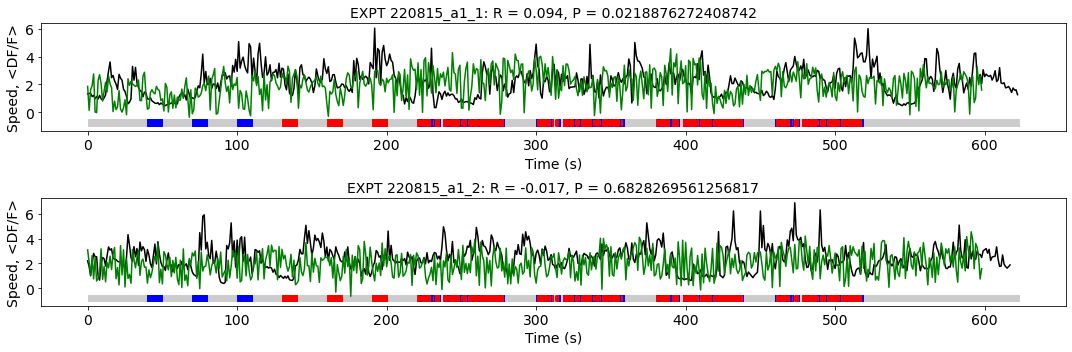

In [9]:
# comparison of mean ROI response and speed
dff_mns = []

for dffs in dffs_all:
    temp = dffs.copy()
    temp[np.isinf(temp)] = np.nan
    dff_mn = np.nanmean(temp, axis=0)
    dff_mns.append(dff_mn)

fig, axs = plt.subplots(len(expts), 1, figsize=(15, 2.5*len(expts)), tight_layout=True)
for ax, expt, dff_mn, spd in zip(axs, expts, dff_mns, spds):
    mvalid = ~np.isnan(dff_mn) & ~np.isnan(spd)
    slp, icpt, r, p, stderr = linregress(dff_mn[mvalid], spd[mvalid])
    
    ax.plot(spd/np.nanstd(spd), c='k')
    ax.plot(tbase, zscore(dff_mn)+2, c='green')
    
    plot_b(ax, tstim, stim, extent=[0, tstim.max(), -1, -.5], c=[(.8, .8, .8), 'b', 'r'])
    set_plot(ax, x_label='Time (s)', y_label='Speed, <DF/F>', title=f'EXPT {expt}: R = {r:.3f}, P = {p}', font_size=14)